In [33]:
%%local
import os
username = os.environ['JUPYTERHUB_USER']
get_ipython().run_cell_magic('configure', line="-f", cell='{ "name":"%s-final-istaden", "executorMemory":"4G", "executorCores":4, "numExecutors":10, "driverMemory": "4G" }' % username)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6681,application_1618324153128_6283,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6358,application_1618324153128_5874,pyspark,idle,Link,Link,None,
6406,application_1618324153128_5941,pyspark,idle,Link,Link,None,
6462,application_1618324153128_6023,pyspark,busy,Link,Link,None,
6533,application_1618324153128_6110,pyspark,idle,Link,Link,None,
6556,application_1618324153128_6136,pyspark,busy,Link,Link,None,
6574,application_1618324153128_6156,pyspark,idle,Link,Link,None,
6575,application_1618324153128_6161,pyspark,idle,Link,Link,None,
6576,application_1618324153128_6163,pyspark,idle,Link,Link,None,
6620,application_1618324153128_6218,pyspark,idle,Link,Link,None,
6632,application_1618324153128_6233,pyspark,idle,Link,Link,None,


In [34]:
%%send_to_spark -i username -t str -n username

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'username' as 'username' to Spark kernel

In [35]:
#Loading the data 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
df = spark.read.orc('/data/sbb/orc/istdaten')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
df=df.selectExpr('betriebstag as date',
                 'produkt_id as transport_type',
                 'haltestellen_name as stop_name',
                 'ankunftszeit as arrival_scheduled',
                 'an_prognose as arrival_actual',
                 'durchfahrt_tf as stop_skip',
                 'bpuic as stop_id',
                  'linien_text as line_name',
                  'verkehrsmittel_text as line_type'
                )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
import pyspark.sql.functions as F

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
#convert day of the trips between
df = df.withColumn('date', F.to_timestamp('date', "dd.MM.yyyy"))
df = df.withColumn('arrival_scheduled', F.to_timestamp('arrival_scheduled', "dd.MM.yyyy HH:mm"))
df = df.withColumn('arrival_actual', F.to_timestamp('arrival_actual', 'dd.MM.yyyy HH:mm:ss'))    

#keep only rows for stops that are not skipped
df=df.filter(df.stop_skip==False)

#keep only rows for stops during the week
df=df.withColumn("day_of_week",F.dayofweek(df.date))
df=df.filter(df.day_of_week.between(2,6))

#hours between 8am and 8pm
min_day_hour,max_day_hour=8,20
df = df.filter(F.hour(F.col('arrival_scheduled')).cast('int').between(min_day_hour, max_day_hour))

#only keep stops within the 15km radius
reachable_stops_path="/user/%s/final/parquet/reachable_stops" %username
stop_id_reachable=spark.read.parquet(reachable_stops_path)
stop_id_reachable=stop_id_reachable.withColumn("stop_id",F.split(stop_id_reachable.stop_id,':')[0])

df=df.join(stop_id_reachable,on="stop_id")

#add hour column
df=df.withColumn("hour",F.hour(F.col("arrival_scheduled")))


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
#filter the rows where transport_type is null
df=df.where((F.col("transport_type")=="Tram") | (F.col("transport_type")=="Zug")|(F.col("transport_type")=="Bus"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
df.select("transport_type").distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|transport_type|
+--------------+
|          Tram|
|           Zug|
|           Bus|
+--------------+

In [67]:
stop_id_reachable.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
|stop_id|
+-------+
|8503306|
|8591274|
|8591209|
|8576170|
|8502209|
|8503378|
|8591201|
|8590588|
|8590681|
|8588984|
+-------+
only showing top 10 rows

In [68]:
#computing actual delays
@F.udf
def relu(x):
    return max(x,0)
df=df.withColumn("delay",relu((F.col("arrival_actual").cast("long")-F.col("arrival_scheduled").cast("long"))))
df = df.where(~(F.col('delay').isNull()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
#statistics type of transport average delays
transport_avg_delays=df.groupby("transport_type").agg(F.mean('delay'))
transport_avg_delays.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----------------+
|transport_type|       avg(delay)|
+--------------+-----------------+
|          Tram|63.99676229368708|
|           Zug|61.34423495288514|
|           Bus|87.97392379025952|
+--------------+-----------------+

In [70]:
transport_avg_delays=transport_avg_delays.withColumnRenamed("avg(delay)","avg_delay")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
transport_avg_delays.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----------------+
|transport_type|        avg_delay|
+--------------+-----------------+
|          Tram|63.99676229368708|
|           Zug|61.34423495288514|
|           Bus|87.97392379025952|
+--------------+-----------------+

In [72]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (30,8)
plt.rcParams['font.size'] = 12
plt.style.use('fivethirtyeight')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
import matplotlib.pyplot as plt
# Plot transport average delays

t_avg_delays_plot=transport_avg_delays.toPandas()

plt.bar(x=t_avg_delays_plot.transport_type,height=t_avg_delays_plot.avg_delay)
#transport_avg_delays["avg_delay"].plot.bar
plt.xlabel('average delay distribution by train')
plt.ylabel('average delay (seconds)')
plt.xticks(range(len(t_avg_delays_plot)), t_avg_delays_plot.transport_type)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

([<matplotlib.axis.XTick object at 0x7f4982a5ae50>, <matplotlib.axis.XTick object at 0x7f49b1c849d0>, <matplotlib.axis.XTick object at 0x7f49829ab810>], <a list of 3 Text xticklabel objects>)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

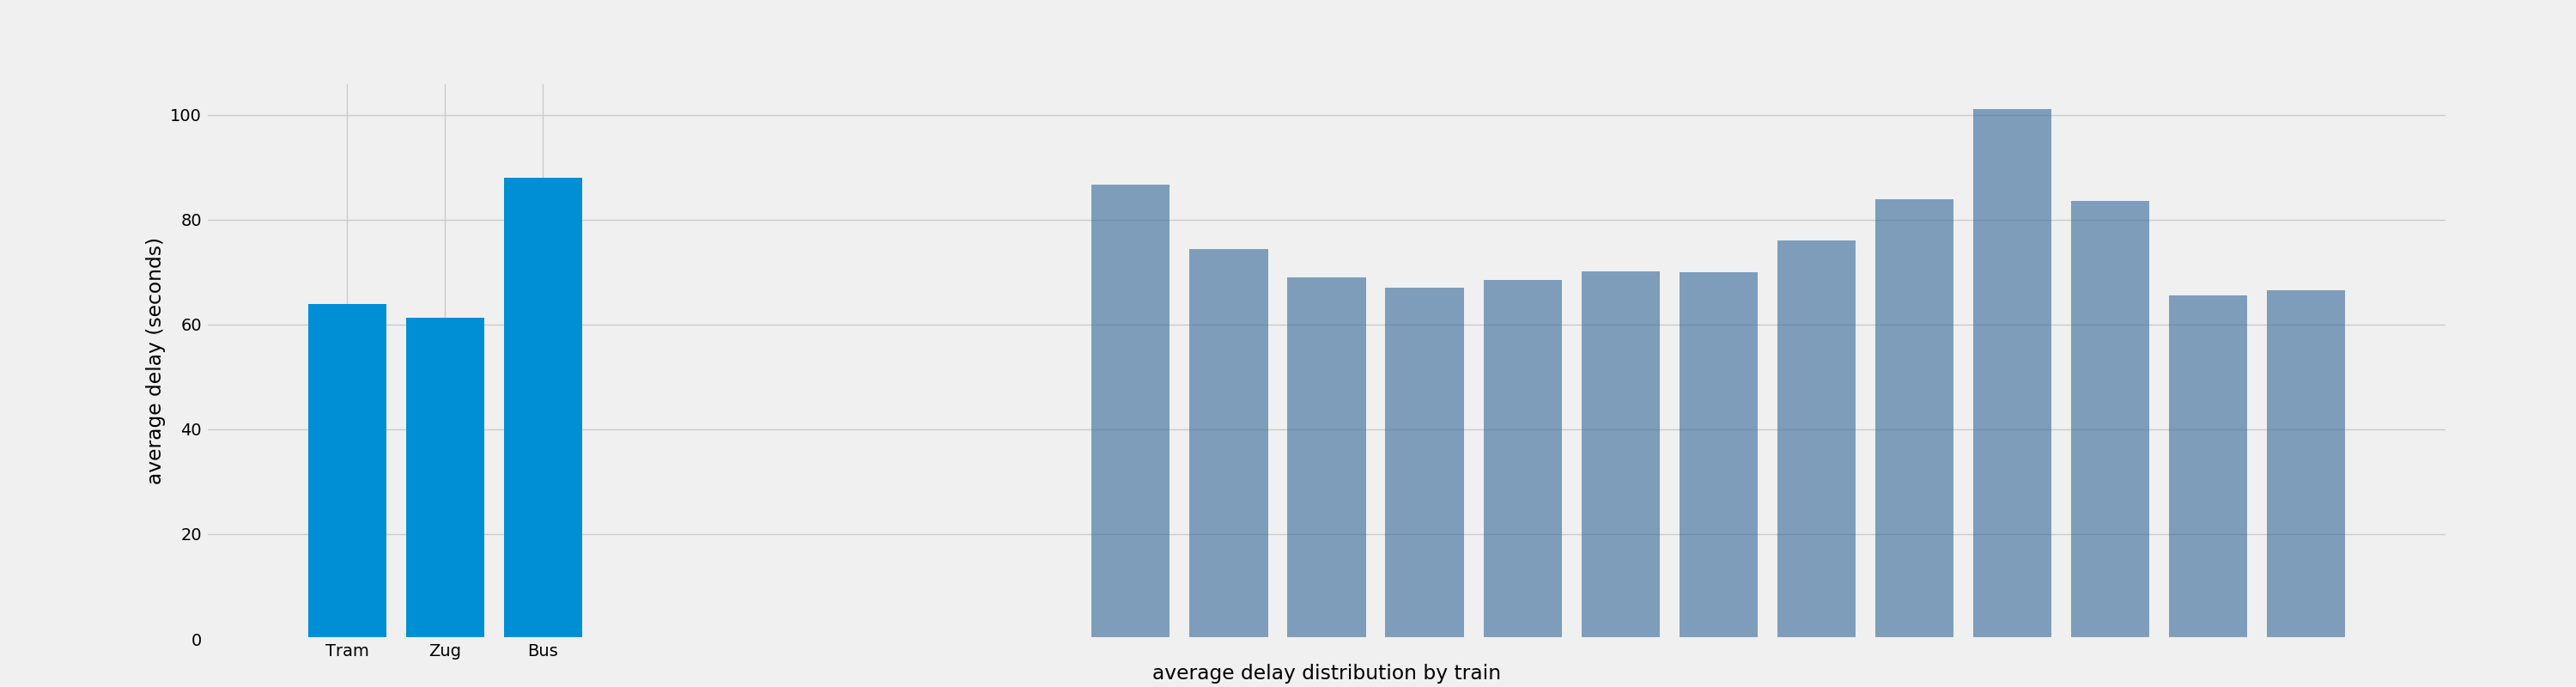

In [74]:
%matplot plt

In [75]:
hour_avg_delays=df.groupby("hour").agg(F.mean('delay'))

hour_avg_delays=hour_avg_delays.withColumnRenamed("avg(delay)","avg_delay")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

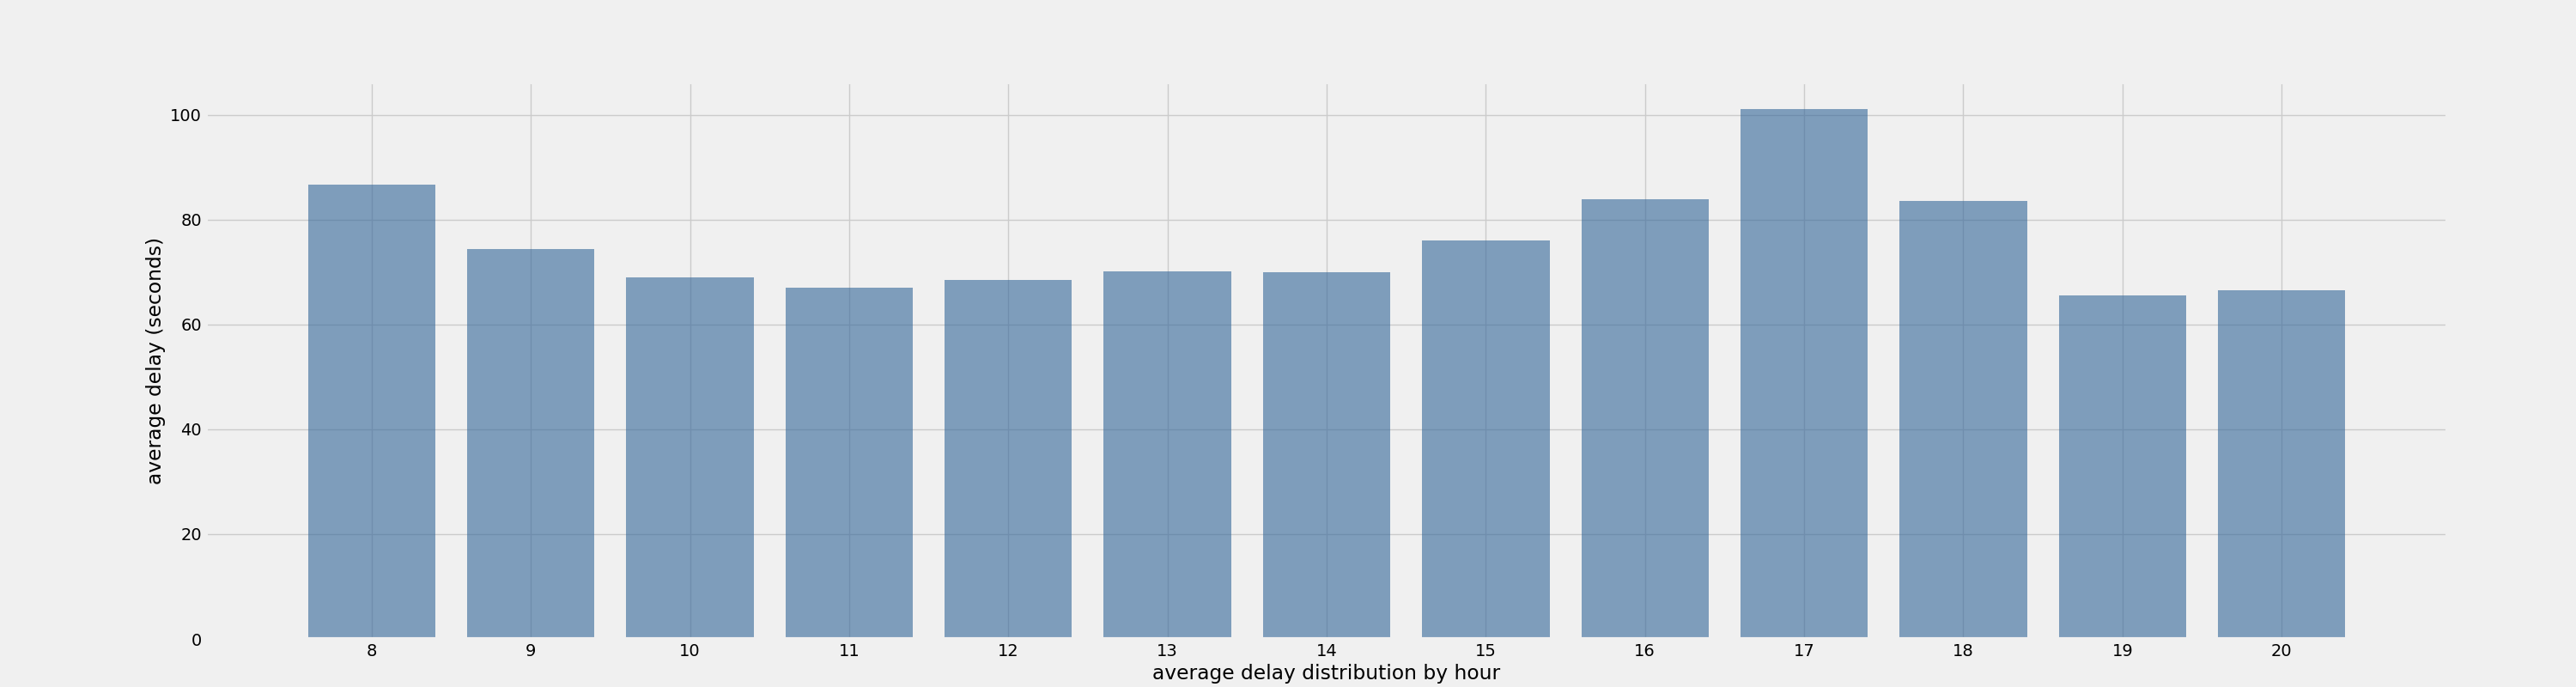

In [76]:
# Plot transport average delays
plt.cla()
h_avg_delays_plot=hour_avg_delays.toPandas().sort_values(by="hour").reset_index(drop=True)

plt.bar(x=h_avg_delays_plot.hour, height=h_avg_delays_plot.avg_delay, color=(0.2, 0.4, 0.6, 0.6))
 
plt.xlabel('average delay distribution by hour')
plt.ylabel('average delay (seconds)')
plt.xticks(h_avg_delays_plot.hour)
# Show the graph
%matplot plt

In [77]:
h_avg_delays_plot

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    hour   avg_delay
0      8   86.795467
1      9   74.446170
2     10   68.969857
3     11   67.005302
4     12   68.443827
5     13   70.088751
6     14   70.033427
7     15   76.117962
8     16   83.957700
9     17  101.163273
10    18   83.672957
11    19   65.614738
12    20   66.623194

In [113]:
train_types=df.where(F.col("transport_type")=="Zug").groupby("line_type","hour").agg(F.mean('delay'))
train_types.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+------------------+
|line_type|hour|        avg(delay)|
+---------+----+------------------+
|       IC|  13| 69.77952960745439|
|      ICE|  13| 75.14521841794569|
|       RE|  20| 49.37491999409187|
|       AG|   8|            1814.0|
|       EC|  14| 206.6857509994289|
|      EXT|  12|120.89573459715639|
|      ICE|  14|263.68567460479557|
|       AG|  14|               0.0|
|        S|   8| 84.01364082789692|
|      ZUG|   9|              83.5|
|       NJ|  11|            1045.8|
|       IC|  19|110.40499973081134|
|      RJX|  12|              45.0|
|       IR|  14|50.990735721840295|
|      ICE|  11|63.494960806270996|
|       EC|  19| 565.6540248459752|
|       RE|   8| 70.16618633600542|
|      TGV|  20|422.98501872659176|
|      ZUG|  12|             362.0|
|       RE|  12| 33.10614318934016|
+---------+----+------------------+
only showing top 20 rows

In [114]:
bus_types=df.where(F.col("transport_type")=="Bus").groupby("line_name").agg(F.mean('delay'))
bus_types.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------------+
|line_name|        avg(delay)|
+---------+------------------+
|      451| 82.52002079033552|
|      919| 66.11488035637656|
|      307|107.98843247350868|
|      205| 51.10120391647517|
|      743|  86.2928960500865|
|      155| 43.49989584516911|
|      132|25.786480406931265|
|      727| 81.20237401123356|
|      200|115.79231817776903|
|      521| 74.97075354072875|
|      961| 137.5145813802553|
|       69| 67.50659419637475|
|      309| 99.43202154292194|
|      703|121.41838113200617|
|      974| 79.19863145502705|
|       73|  74.3761608040201|
|       64| 62.32576592517063|
|      308| 94.99145552397123|
|      910| 95.08755089755076|
|      652| 91.41329678616052|
+---------+------------------+
only showing top 20 rows

In [115]:
tram_types=df.where(F.col("transport_type")=="Tram").groupby("line_name").agg(F.mean('delay'))
tram_types.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------------+
|line_name|        avg(delay)|
+---------+------------------+
|        7|  69.8878063016985|
|       15| 75.00601441653484|
|       11| 66.86055264518396|
|        3| 59.33061610213354|
|        8| 70.40891044996407|
|        E| 90.85397553516819|
|        5| 59.46522312547608|
|       17|  68.8109536244329|
|        6| 56.65332733859282|
|       8E|   71.322913028292|
|        9|57.409503574474954|
|       10| 70.00171260225294|
|        4| 69.85353917808457|
|       12| 51.51746101772522|
|       13| 69.13658160251748|
|       14|57.614791397629645|
|        2| 54.24695457437215|
+---------+------------------+

In [116]:
df=df.withColumn("hour",F.hour(F.col("arrival_scheduled")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
train_types_hour=df.where(F.col("transport_type")=="Zug").groupby("line_type","hour").agg(F.mean('delay'))
train_types_hour.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+------------------+
|line_type|hour|        avg(delay)|
+---------+----+------------------+
|       IC|  13| 69.77952960745439|
|      ICE|  13| 75.14521841794569|
|       RE|  20| 49.37491999409187|
|       AG|   8|            1814.0|
|       EC|  14| 206.6857509994289|
|      EXT|  12|120.89573459715639|
|      ICE|  14|263.68567460479557|
|       AG|  14|               0.0|
|        S|   8| 84.01364082789692|
|      ZUG|   9|              83.5|
|       NJ|  11|            1045.8|
|       IC|  19|110.40499973081134|
|      RJX|  12|              45.0|
|       IR|  14|50.990735721840295|
|      ICE|  11|63.494960806270996|
|       EC|  19| 565.6540248459752|
|       RE|   8| 70.16618633600542|
|      TGV|  20|422.98501872659176|
|      ZUG|  12|             362.0|
|       RE|  12| 33.10614318934016|
+---------+----+------------------+
only showing top 20 rows

In [118]:
bus_types_hour=df.where(F.col("transport_type")=="Bus").groupby("line_name","hour").agg(F.mean('delay'))
bus_types_hour.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+------------------+
|line_name|hour|        avg(delay)|
+---------+----+------------------+
|      650|   9|161.08842957130358|
|      652|  19| 63.30388307741953|
|      754|  17|157.32562378340117|
|      245|  11| 69.85999313481507|
|      134|  12| 45.02939023497548|
|      155|   8| 58.03131163708087|
|      811|  18|101.79324439212608|
|      842|  17| 134.4118087335871|
|      973|  17| 86.01799626906617|
|       32|  18| 104.4351895192534|
|       40|  14| 93.80258306888183|
|       75|  19| 80.64258898169436|
|      751|  18| 88.79274183091286|
|      305|  11| 79.59240239647113|
|      309|  18| 79.25972776917435|
|      912|  19|51.264625526246704|
|      759|  12|  76.9040294672929|
|      795|  18| 82.79540081667741|
|      245|  19| 47.02799414348463|
|      225|  15| 67.28446670954203|
+---------+----+------------------+
only showing top 20 rows

In [119]:
tram_types_hour=df.where(F.col("transport_type")=="Tram").groupby("line_name","hour").agg(F.mean('delay'))
tram_types_hour.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----+------------------+
|line_name|hour|        avg(delay)|
+---------+----+------------------+
|       14|  10| 55.37009190703116|
|        5|  15| 66.51267330325216|
|        8|  18| 88.76431724137932|
|        7|  16| 77.59871650151553|
|        8|  19| 68.62609447355867|
|       14|   9| 51.88008392200643|
|       15|  11| 69.42126711721973|
|        3|  13| 57.00602907371504|
|       13|  19| 68.37475685234305|
|       8E|   9| 69.49776785714286|
|        9|   8| 58.05699694718815|
|        9|  18| 47.47692869329777|
|       14|  18|62.205553500097196|
|       17|  19| 62.22989701445959|
|        3|   8|62.483166967097674|
|       15|  14| 75.62902567937323|
|        2|  20| 54.93717576796998|
|        3|  19| 54.46267692001724|
|       8E|  10| 80.52232142857143|
|       12|  20|51.545313676774846|
+---------+----+------------------+
only showing top 20 rows

In [123]:
transport_avg_delays.write.parquet('/user/%s/final/parquet/transport_avg_delays' % username)
hour_avg_delays.write.parquet('/user/%s/final/parquet/hour_avg_delays' % username)
train_types.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/train_types' % username)
bus_types.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/bus_types' % username)
tram_types.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/tram_types' % username)
train_types_hour.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/train_types_hour' % username)
bus_types_hour.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/bus_types_hour' % username)
tram_types_hour.withColumnRenamed("avg(delay)","avg_delay").write.parquet('/user/%s/final/parquet/tram_types_hour' % username)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [127]:
default_delay = df.select(F.mean(F.col('delay')).alias('mean_delay'),).collect()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
default_delay.show()